<a href="https://colab.research.google.com/github/SHIVANANDA23/ARM_LPC2148_RTOS/blob/main/BERT_UPDATED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from transformers import BertTokenizer, BertForMaskedLM, AdamW
import torch
from tqdm import tqdm

In [7]:
import os

def read_text_files(folder_path):
    # Get the list of files in the specified folder
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # String to store the concatenated content of text files
    concatenated_content = ""

    # Iterate through each file and read its content
    for file in files:
        if file.endswith('.txt'):
            file_path = os.path.join(folder_path, file)
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    content = f.read()
                    concatenated_content += content
            except Exception as e:
                print(f"Error reading {file}: {str(e)}")
                continue

    return concatenated_content

# Specify the path to the folder containing text files
folder_path = '/content/drive/MyDrive/ML DATASET/UPDATED'

# Call the function to read and concatenate text files in the specified folder
custom_text_data = read_text_files(folder_path)

custom_text_data = custom_text_data.lower()  # Uncomment this line if you want to convert the text to lowercase
print(type(custom_text_data))
print(custom_text_data[58042104:58042200])  # Print the first 100 characters as a sample
print(len(custom_text_data))

Error reading cached_lm_BertTokenizer_126_10-Ways-to-Write-More-Effective-Ads.txt: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte
<class 'str'>
ed. i had a new message. my heart beat fast as i
is
‘phil, do you want to?’ mr gates said.
epilo
58042204


In [8]:
import re
custom_text_data = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", custom_text_data)

In [9]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize your custom dataset
encoded_data = tokenizer(custom_text_data, return_tensors='pt', padding=True, truncation=True)

# Mask a certain percentage of tokens in the dataset for MLM training
mask_probability = 0.15
rand = torch.rand(encoded_data.input_ids.shape)
mask_arr = rand < mask_probability
selection = []

for i in range(mask_arr.shape[0]):
    selection.append(torch.flatten(mask_arr[i].nonzero()).tolist())
    encoded_data.input_ids[i, selection[i]] = tokenizer.mask_token_id

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)


In [10]:
# Create your custom dataset
dataset = CustomDataset(encoded_data)

# DataLoader setup
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

# Load BERT model
model = BertForMaskedLM.from_pretrained("bert-base-uncased")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.train()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-15-938050dcd06c>:41: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  accuracy = np.mean(predictions == targets)
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  3.61it/s, accuracy=0, loss=0.00216]


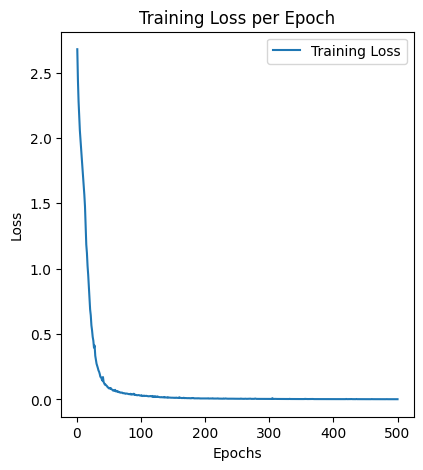

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from transformers import AdamW
from tqdm import tqdm

# Define lists to store loss and accuracy values
train_loss_values = []
train_accuracy_values = []

optimizer = AdamW(model.parameters(), lr=1e-5)
epochs = 500

for epoch in range(epochs):
    loop = tqdm(dataloader, leave=True)
    total_train_loss = 0.0
    total_train_accuracy = 0.0
    total_steps = 0

    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['input_ids'].to(device)
        # Assuming your labels are under a key named 'target_labels'
        #labels = batch['target_labels'].to(device)


        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_steps += 1

        # Calculate accuracy
        predictions = np.argmax(logits.detach().cpu().numpy(), axis=1)
        targets = labels.detach().cpu().numpy()
        accuracy = np.mean(predictions == targets)
        total_train_accuracy += accuracy

        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item(), accuracy=accuracy)

    # Calculate average loss and accuracy for the epoch
    epoch_train_loss = total_train_loss / total_steps
    epoch_train_accuracy = total_train_accuracy / total_steps
    train_loss_values.append(epoch_train_loss)
    train_accuracy_values.append(epoch_train_accuracy)

# Plotting the loss and accuracy
epochs_list = list(range(1, epochs + 1))

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()



In [ ]:
def predict_next_word(input_word, model, tokenizer, device):
    model.eval()

    # Create a sentence template with a masked token
    input_text = f"I want to {tokenizer.mask_token} {input_word}"

    # Tokenize input text
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)

    # Generate predictions for the masked token
    with torch.no_grad():
        outputs = model(input_ids)
        predictions = outputs.logits  # Output scores for tokens

    # Get the index of the predicted token (assuming only one [MASK] token in input)
    mask_token_index = (input_ids.squeeze() == tokenizer.mask_token_id).nonzero().item()

    # Get the top predicted token's index
    predicted_token_index = torch.argmax(predictions[0, mask_token_index]).item()

    # Convert the predicted token index back to the actual token
    predicted_token = tokenizer.decode([predicted_token_index])

    return predicted_token

# Example usage:
while(True):
  user_input = input("Enter a word: ")
  if(input!='0'):
      predicted_word = predict_next_word(user_input, model, tokenizer, device)
      print(f"Predicted word to complete the sentence: {user_input} {predicted_word}'")
  else:
    break;